In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import Pauli
import numpy as np
# General imports
import time
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# The IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Session

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [3]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import scipy
from scipy.optimize import minimize
import networkx as nx
import seaborn
import itertools

np.random.seed(42)

C:\Users\Dylan\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
QiskitRuntimeService.save_account(channel="ibm_quantum", instance="rpi/general/general", token="ce8b8b4a0d2fbdffaedd26b6177808d2676f00303010eca8c0b6366850249f277834be8b1d5f7f0e62ed31cd6d956a973a4dd155b441c15c71df44989c01b890", name="general", overwrite=True)

In [5]:
import numpy as np
from qiskit.opflow import PauliSumOp, Z, I

def random_ising_hamiltonian(num_qubits):
    # Generate random coefficients for the ZZ terms and Z terms
    J = np.random.rand(num_qubits - 1)  # Coupling strengths
    h = np.random.rand(num_qubits)  # External magnetic field strengths
    
    # Create the ZZ interaction terms
    zz_terms = []
    for i in range(num_qubits - 1):
        op_str = 'I' * i + 'ZZ' + 'I' * (num_qubits - i - 2)
        zz_terms.append(PauliSumOp.from_list([(op_str, -J[i])]))
    
    # Create the Z field terms
    z_terms = []
    for i in range(num_qubits):
        op_str = 'I' * i + 'Z' + 'I' * (num_qubits - i - 1)
        z_terms.append(PauliSumOp.from_list([(op_str, -h[i])]))
    
    # Combine the terms
    hamiltonian = sum(zz_terms + z_terms)
    
    return hamiltonian

# Example usage:
num_qubits = 10
hamiltonian = random_ising_hamiltonian(num_qubits) + random_ising_hamiltonian(num_qubits) + random_ising_hamiltonian(num_qubits)

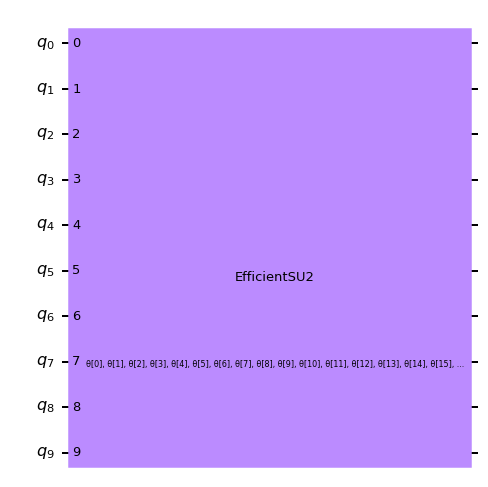

In [6]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.draw("mpl")

In [7]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

In [8]:
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)

In [9]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        callback_dict["cost_history"].append(
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        )
        # Grab the current time
        current_time = time.perf_counter()
        # Find the total time of the execute (after the 1st iteration)
        if callback_dict["iters"] > 1:
            callback_dict["_total_time"] += current_time - callback_dict["_prev_time"]
        # Set the previous time to the current time
        callback_dict["_prev_time"] = current_time
        # Compute the average time per iteration and round it
        time_str = (
            round(callback_dict["_total_time"] / (callback_dict["iters"] - 1), 2)
            if callback_dict["_total_time"]
            else "-"
        )
        # Print to screen on single line
        print(
            "Iters. done: {} [Avg. time per iter: {}] Cost: {}".format(callback_dict["iters"], time_str, str(callback_dict["cost_history"][-1])),
            end="\r",
            flush=True,
        )

    return callback

In [10]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "_total_time": 0,
    "_prev_time": None,
}
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
service = QiskitRuntimeService(channel="ibm_quantum", instance="rpi/general/general", token="ce8b8b4a0d2fbdffaedd26b6177808d2676f00303010eca8c0b6366850249f277834be8b1d5f7f0e62ed31cd6d956a973a4dd155b441c15c71df44989c01b890")
# Set options, which can be overwritten at job level.
options = Options()
options.resilience_level = 2
options.optimization_level = 3

In [11]:
service.backends()

[<IBMBackend('ibm_algiers')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_cusco')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>]

In [12]:
with Session(service=service, backend="ibm_sherbrooke"):
    estimator = Estimator(options=options)
    callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
    res = minimize(
        cost_func,
        x0,
        args=(ansatz, hamiltonian, estimator),
        method="cobyla",
        callback=callback,
        options={'maxiter': 300},
    )

runtime_job._start_websocket_client:WARNING:2023-10-11 22:17:02,757: An error occurred while streaming results from the server for job cmkj5yztv5jg008ep460:
Traceback (most recent call last):
  File "C:\Users\Dylan\AppData\Roaming\Python\Python38\site-packages\qiskit_ibm_runtime\runtime_job.py", line 500, in _start_websocket_client
    self._ws_client.job_results()
  File "C:\Users\Dylan\AppData\Roaming\Python\Python38\site-packages\qiskit_ibm_provider\api\clients\runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "C:\Users\Dylan\AppData\Roaming\Python\Python38\site-packages\qiskit_ibm_provider\api\clients\base.py", line 230, in stream
    raise WebsocketError(error_message)
qiskit_ibm_provider.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\websocket\\_http.py", line

RequestsApiError: "HTTPSConnectionPool(host='api.quantum-computing.ibm.com', port=443): Max retries exceeded with url: /runtime/jobs/cmkj5yztv5jg008ep460 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001F91E241580>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))"

In [38]:
reference = -15.616895977394143

Text(0, 0.5, 'Cost')

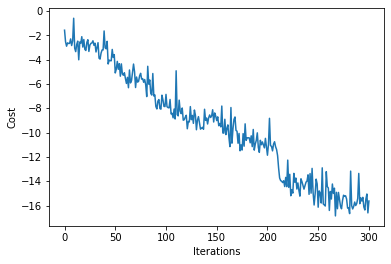

In [13]:
fig, ax = plt.subplots()
ax.plot(callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

In [14]:
min_prior = min(callback_dict["cost_history"])

In [15]:
print(min_prior)

-16.844329702435438
